In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
from statistics import mean, median
import xml.etree.ElementTree as et
import string
from collections import Counter
import collections

import helper_functions

# Georgia 2020 State House Election Results

## Election Results Documentation:

Election results from the Georgia Secretary of State Elections Division (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results). Presidential recount results from the Georgia Secretary of State Elections Division via Reuters.

## Shapefile Source Documentation:

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  
Cobb, DeKalb, and Gwinnett counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program.  
Forsyth and Fulton use shapefiles sourced from the respective counties.

## Shapefile Modifications Documentation:

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election.

Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary  
Bartow: Split Cassville/Hamilton Crossing  
Candler: Merge Candler/Metter as Jack Strickland Comm Center  
Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C  
Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile  
Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5   
Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B  
Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps  
Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre  
Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035  
DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits   
Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G  
Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU  
Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits  
Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019  
Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman  
Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps  
Towns: Merge Macedonia/Tate City  
Wilkes: Align 1/2A boundary with the voter file    
Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

## Candidate List

See the README for a full list of candidate names

## Election Results Processing

### Load the modified VEST file

Note: This is the modified version of the file created in the statewide notebook

In [2]:
vest_ga_20 = gp.read_file("./raw-from-source/VEST/cleaned_ga_2020/cleaned_ga_2020.shp")
print(vest_ga_20.shape)

(2678, 50)


In [3]:
# Take a look
vest_ga_20.head(1)

#Create a list of the race columns
data_columns = [i for i in vest_ga_20.columns if (("20" in i) | ("21" in i))]
print(data_columns)

['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER', 'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA', 'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC', 'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN', 'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR', 'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL', 'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS', 'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA']


### 1. Load General Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [4]:
loaded_counties = os.listdir("./raw-from-source/Non_Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Non_Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
ga_election = pd.DataFrame(z,columns=dfcols)

#Sanity check that there are the right number of counties
print(len(ga_election["county"].unique()))

159


### Update Race Names

In [5]:
race_name_change_dict = {

    'State House Dist 81/Estatal ante la Asamblea General Dist 81':'State House District 81',
    'State House Dist 93/Estatal ante la Asamblea General Dist 93':'State House District 93',
    'State House Dist 94/Estatal ante la Asamblea General Dist 94':'State House District 94',
    'State House Dist 95/Estatal ante la Asamblea General Dist 95':'State House District 95',
    'State House Dist 96/Estatal ante la Asamblea General Dist 96':'State House District 96',
    'State House Dist 97/Estatal ante la Asamblea General Dist 97':'State House District 97',
    'State House Dist 98/Estatal ante la Asamblea General Dist 98':'State House District 98',
    'State House Dist 99/Estatal ante la Asamblea General Dist 99':'State House District 99',
    'State House Dist 100/Estatal ante la Asamblea General Dist 100':'State House District 100',
    'State House Dist 101/Estatal ante la Asamblea General Dist 101':'State House District 101',
    'State House Dist 102/Estatal ante la Asamblea General Dist 102':'State House District 102',
    'State House Dist 103/Estatal ante la Asamblea General Dist 103':'State House District 103',
    'State House Dist 104/Estatal ante la Asamblea General Dist 104':'State House District 104',
    'State House Dist 105/Estatal ante la Asamblea General Dist 105':'State House District 105',
    'State House Dist 106/Estatal ante la Asamblea General Dist 106':'State House District 106',
    'State House Dist 107/Estatal ante la Asamblea General Dist 107':'State House District 107', 
    'State House Dist 108/Estatal ante la Asamblea General Dist 108':'State House District 108', 
    'State House Dist 114/Estatal ante la Asamblea General Dist 114':'State House District 114',

}

ga_election["contest"] = ga_election["contest"].map(race_name_change_dict).fillna(ga_election["contest"])

In [6]:
total_races_list = list(ga_election["contest"].unique())

ga_house_races = [i for i in total_races_list if "State House" in i]


### Filter Down to Relevant Races

In [7]:
ga_election = ga_election[ga_election["contest"].isin(ga_house_races)]
ga_election.reset_index(inplace=True,drop=True)

### Clean and Pivot Data

In [8]:
#Make sure votes are integers
ga_election["num_votes"] = ga_election["num_votes"].astype(int)

In [9]:
def conditions(x):
    if "(" in x:
        return x[len(x)-4:len(x)-1].upper()
    else:
        raise ValueError

In [10]:
func = np.vectorize(conditions)
party = func(ga_election["choice"])
ga_election["party"] = party

In [11]:
def district_assigner(x):
    if "District" in x:
        return x.split( )[len(x.split( ))-1].zfill(2)
    else:
        raise ValueError

In [12]:
func = np.vectorize(district_assigner)
district = func(ga_election["contest"])
ga_election["DISTRICT"] = district

In [13]:
ga_election["DISTRICT"] = ga_election["DISTRICT"].astype(str).str.zfill(3)

#### Add a FIPS Column

In [14]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
ga_election['county_fips'] = ga_election['county'].map(fips_dict).fillna(ga_election['county'])
ga_election['county_fips'] = ga_election['county_fips'].astype(str)
ga_election['county_fips'] = ga_election['county_fips'].str.zfill(3)

#### Create a Precinct to District Mapping DataFrame

In [15]:
choice_change_dict = {}
choice_change_dict_holder = {}
def get_name(full_name):
    
    if full_name in list(choice_change_dict.keys()):
        #print(full_name + " - "+ choice_change_dict[full_name])
        return choice_change_dict[full_name]
    else:
        last_name = full_name.split(" ")[-1]
        last_name = last_name.upper()
        if last_name in ["JR.", "III"]:
                last_name = full_name.split(" ")[-2]
                last_name = last_name.upper()
        #print(full_name + " - "+last_name[0:3])
        if full_name not in list(choice_change_dict_holder.keys()):
            choice_change_dict_holder[full_name] = last_name[0:3]
        return last_name[0:3]


In [16]:
ga_election["cand"] = ga_election["choice"].apply(lambda x:x.split(" (")[0])
ga_election.sort_values(["cand"], inplace = True)
ga_election["cand_abbrev"] =  ga_election["cand"].apply(lambda x: get_name(x))
ga_election["unique_ID"] = ga_election["county_fips"]+"-"+ga_election["precinct"]

In [17]:
# Print statement to check the name mapping
# for val in choice_change_dict_holder:
#     print(val, "-", choice_change_dict_holder[val])

In [18]:
# Define the more detailed choice column
ga_election["mod_choice"]="GSL"+ga_election["DISTRICT"]+ga_election["party"].str[0]+ga_election["cand_abbrev"]

In [19]:
# Create a Fields Dictionary
fields_dict_lower = dict(zip(ga_election["mod_choice"],ga_election["choice"]))
od = collections.OrderedDict(sorted(fields_dict_lower.items()))
fields_dict_lower_df = pd.DataFrame.from_dict(od, orient ='index')
fields_dict_lower_df.reset_index(inplace = True, drop = False)
fields_dict_lower_df.columns = ['Field_Name', 'Cand_Name']
fields_dict_lower_df.to_csv("./sldl_fields_dict.csv", index = False)

#### Pivot the data

In [20]:
ga_election["unique_ID"]=ga_election["county_fips"]+ga_election["precinct"]
ga_election=pd.pivot_table(ga_election,index=["unique_ID","county","county_fips","precinct"],columns=["mod_choice"],values=['num_votes'],aggfunc=sum)
ga_election = ga_election.fillna(0)
ga_election.columns = ga_election.columns.droplevel(0)
ga_election = ga_election.reset_index()

### Combine Northgate Assembly and Trinity in Election Results

Note: We perfomed this in the modified version of the VEST file as well. This corrects an issue with votes appearing in a precinct outside of a congressional district. Please see the main file README for more information

In [21]:
to_remove = ga_election[(ga_election["county"]=="Lowndes") & (ga_election["precinct"].isin(["Northgate Assembly", "Trinity"]))]
remaining_elections = ga_election[~((ga_election["county"]=="Lowndes") & (ga_election["precinct"].isin(["Northgate Assembly", "Trinity"])))]

In [22]:
# Print statements to make sure all precincts are counted correctly
print(ga_election.shape)
print(remaining_elections.shape)
print(to_remove.shape)

(2656, 271)
(2654, 271)
(2, 271)


In [23]:
# Combine the two precincts and clean the indices
grouped_to_remove = to_remove.groupby(["county_fips"]).sum()
grouped_to_remove.reset_index(inplace = True, drop = False)

# Add appropriate data columns and filter down to needed columns
grouped_to_remove["unique_ID"] = "185-NORTHGATE ASSEMBLY AND TRINITY"
grouped_to_remove["county"] = 'Lowndes'
grouped_to_remove["county_fips"] = '185' 
grouped_to_remove["precinct"] = 'NORTHGATE ASSEMBLY AND TRINITY'
grouped_to_remove = grouped_to_remove[list(to_remove.columns)]

# Combine the precincts back together
ga_election = pd.concat([remaining_elections, grouped_to_remove])
ga_election.reset_index(inplace = True, drop = True)

## Join Election Results to Shapefiles

#### Try a  unique ID

In [24]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_N"]

#### Check whether there are duplicate IDs

In [25]:
ser_1 = ga_election["unique_ID"].value_counts(dropna=False)
print(ser_1[ser_1 >1])

ser_2 = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser_2[ser_2 >1])

Series([], Name: unique_ID, dtype: int64)
NaN                        7
051-ELI WHITNEY COMPLEX    2
Name: unique_ID, dtype: int64


In [26]:
#Look into duplicate IDs - ELI WHITNEY
display(vest_ga_20[vest_ga_20["unique_ID"]=="051-ELI WHITNEY COMPLEX"])

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,G20PSCDBLA,G20PSCLWIL,R21USSRPER,R21USSDOSS,R21USSRLOE,R21USSDWAR,R21PSCRMCD,R21PSCDBLA,geometry,unique_ID
2259,0513-15C,0513-15C,3-15C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,278,361,...,325,15,281,329,282,329,284,318,"POLYGON ((-81.02948 32.06200, -81.03000 32.060...",051-ELI WHITNEY COMPLEX
2261,0512-06C,0512-06C,2-06C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,65,335,...,301,19,52,312,53,311,54,300,"POLYGON ((-81.05333 32.07291, -81.05336 32.072...",051-ELI WHITNEY COMPLEX


In [27]:
#Assign new unique IDs, adding in PRECINCT_I to differentiate
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

In [28]:
vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']

In [29]:
#Create a dictionary of ID changes
source_vest_id_changes_dict = {'051-1-17C ISLANDS CHRISTIAN CHURCH': '051-ISLANDS CHRISTIAN CHURCH', '051-7-14C COASTAL CATHEDRAL': '051-COASTAL CATHEDRAL', '051-7-07C ROTHWELL BAPTIST CHURCH': '051-ROTHWELL BAPTIST CHURCH', '051-4-07C WILMINGTON ISLAND UMC': '051-WILMINGTON ISLAND UMC', '051-4-08C WILMINGTON ISLAND PRES CHURCH': '051-WILMINGTON ISLAND PRES CHURCH', '051-1-16C FERGUSON AVE BAPTIST': '051-FERGUSON AVE BAPTIST', '051-7-11C SEVENTH DAY ADV CHURCH': '051-SEVENTH DAY ADV CHURCH', '051-7-16C POOLER RECREATION CENTER GYMNASIUM': '051-POOLER REC CENTER GYM', '051-7-08C BLOOMINGDALE COMM CTR': '051-BLOOMINGDALE COMM CTR', '051-4-13C SKIDAWAY ISLAND PRES CHURCH': '051-SKIDAWAY ISLAND PRES CHURCH', '051-6-10C STATION 3': '051-GEORGETOWN ELEMENTARY', '051-4-12C ST PETERS EPISCOPAL': '051-ST PETERS EPISCOPAL', '051-7-13C SOUTHSIDE FIRE TRNG CTR': '051-SOUTHSIDE FIRE TRNG CTR', '051-4-06C FIRST BAPTIST OF THE ISLAND': '051-FIRST BAPTIST OF THE ISLAND', '051-4-04C LIGHTHOUSE BAPTIST CHURCH': '051-LIGHTHOUSE BAPTIST CHURCH', '051-4-05C ST FRANCIS EPISCOPAL CHURCH': '051-ST FRANCIS EPISCOPAL CHURCH', '051-1-12C ISLE OF HOPE BAPTIST': '051-ISLE OF HOPE BAPTIST', '051-4-02C FRANK MURRAY COMM CENTER': '051-FRANK MURRAY COMM CENTER', '051-7-06C POOLER CITY HALL': '051-POOLER CITY HALL', '051-8-16C ROYAL CINEMAS AND IMAX': '051-ROYAL CINEMAS AND IMAX', '051-6-02C WINDSOR FOREST BAPTIST': '051-WINDSOR FOREST BAPTIST', '051-6-11C BAMBOO FARMS': '051-BAMBOO FARMS', '051-4-15C SKIDAWAY ISLAND STATE PARK': '051-SKIDAWAY ISLAND STATE PARK', '051-6-09C TRINITY LUTHERAN CHURCH': '051-TRINITY LUTHERAN CHURCH', '051-1-01C FIRST PRESBYTERIAN CHURCH': '051-FIRST PRESBYTERIAN CHURCH', '051-4-14C SKIDAWAY ISLAND BAPTIST': '051-SKIDAWAY ISLAND BAPTIST', '051-7-12C POOLER CHURCH': '051-POOLER CHURCH', '051-7-10C PROGRESSIVE REC CENTER': '051-PROGRESSIVE REC CENTER', '051-1-06C CENTRAL CHURCH OF CHRIST': '051-CENTRAL CHURCH OF CHRIST', '051-1-14C COMPASSION CHRISTIAN CHURCH': '051-COMPASSION CHRISTIAN CHURCH', '051-6-03C CRUSADER COMM CENTER': '051-CRUSADER COMM CENTER', '051-4-11C TYBEE ISLAND SCHOOL CAFE': '051-TYBEE ISLAND SCHOOL CAFE', '051-7-09C SAVANNAH HOLY C OF G': '051-SAVANNAH HOLY C OF G', '051-4-10C GUARD HOUSE COMM CTR': '051-GUARD HOUSE COMM CTR', '051-1-08C GRACE UNITED METHODIST CHURCH': '051-GRACE UNITED METHODIST CHURCH', '051-1-10C ST THOMAS EPISCOPAL CHURCH': '051-ST THOMAS EPISCOPAL CHURCH', '051-1-05C JEA BUILDING': '051-JEA BUILDING', '051-1-13C THE SANCTUARY': '051-THE SANCTUARY', '051-7-15C RICE CREEK SCHOOL': '051-RICE CREEK SCHOOL', '051-3-12C THUNDERBOLT MUNI COMPLEX': '051-THUNDERBOLT MUNI COMPLEX', '051-3-13C NEW COV 7 DAY ADV CH': '051-NEW COV 7 DAY ADV CH', '051-7-03C PB EDWARDS GYM': '051-PB EDWARDS GYM', '051-7-01C GARDEN CITY SENIOR CTR': '051-GARDEN CITY SENIOR CTR', '051-6-06C THE LIGHT CHURCH': '051-THE LIGHT CHURCH', '051-7-04C LAKE SHORE COMM CTR': '051-LAKE SHORE COMM CTR', '051-6-05C WINDSOR HALL': '051-WINDSOR HALL', '051-3-02C TEMPLE MICKVE ISRAEL': '051-TEMPLE MICKVE ISRAEL', '051-6-01C WHITE BLUFF PRESBYTERIAN': '051-WHITE BLUFF PRESBYTERIAN', '051-5-11C LARGO-TIBET ELEMENTARY': '051-LARGO-TIBET ELEMENTARY', '051-3-14C OGLETHORPE CHARTER ACADEMY': '051-OGLETHORPE CHARTER ACADEMY', '051-6-08C CHRIST MEMORIAL BAPTIST CHURCH': '051-CHRIST MEMORIAL BAPTIST CHURCH', '051-7-05C WOODLAWN BAPTIST CHURCH': '051-WOODLAWN BAPTIST CHURCH', '051-5-08C SAVANNAH PRIMITIVE BC': '051-SAVANNAH PRIMITIVE BC', '051-8-03C SILK HOPE BAPTIST CHURCH': '051-SILK HOPE BAPTIST CHURCH', '051-3-05C ALDERSGATE YOUTH CENTER': '051-ALDERSGATE YOUTH CENTER', '051-3-09C COKESBURY METHODIST': '051-COKESBURY METHODIST', '051-3-15C ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 3-15C', '051-8-13C SAVANNAH CHRISTIAN': '051-SAVANNAH CHRISTIAN', '051-5-07C STATION 1': '051-ELKS LODGE', '051-2-09C SALVATION ARMY': '051-SALVATION ARMY', '051-3-10C BIBLE BAPTIST CHURCH': '051-BIBLE BAPTIST CHURCH', '051-2-07C CHRIST COMMUNITY CHURCH': '051-CHRIST COMMUNITY CHURCH', '051-3-08C JENKINS HIGH SCHOOL': '051-JENKINS HIGH SCHOOL', '051-5-06C SEED CHURCH': '051-SEED CHURCH', '051-1-09C IMMANUEL BAPTIST CHURCH': '051-IMMANUEL BAPTIST CHURCH', '051-8-02C HELLENIC CENTER': '051-HELLENIC CENTER', '051-2-11C STILLWELL TOWERS': '051-STILLWELL TOWERS', '051-3-11C SOUTHSIDE BAPTIST CHURCH': '051-SOUTHSIDE BAPTIST CHURCH', '051-2-02C BLACKSHEAR COMMUNITY CENTER': '051-BLACKSHEAR COMMUNITY CENTER', '051-5-01C BARTLETT MIDDLE SCHOOL': '051-BARTLETT MIDDLE SCHOOL', '051-2-05C HOLY SPIRIT LUTHERAN CHURCH': '051-HOLY SPIRIT LUTHERAN CHURCH', '051-2-04C FELLOWSHIP OF LOVE CHURCH': '051-FELLOWSHIP OF LOVE CHURCH', '051-2-12C WILLIAMS COURT APTS': '051-WILLIAMS COURT APTS', '051-3-01C OLD COURTHOUSE': '051-OLD COURTHOUSE', '051-2-03C W W LAW CENTER': '051-W W LAW CENTER', '051-8-12C BEACH HIGH SCHOOL': '051-BEACH HIGH SCHOOL', '051-5-10C TATUMVILLE COMMUNITY CENTER': '051-TATUMVILLE COMMUNITY CENTER', '051-8-15C GARDEN CITY REC CENTER': '051-GARDEN CITY REC CENTER', '051-2-06C ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 2-06C', '051-3-03C SAVANNAH HIGH SCHOOL': '051-SAVANNAH HIGH SCHOOL', '051-8-01C CIVIC CENTER': '051-CIVIC CENTER', '051-3-04C FIRST AFRICAN BAPTIST CHURCH': '051-FIRST AFRICAN BAPTIST CHURCH', '051-5-05C LIBERTY CITY COMM CTR': '051-LIBERTY CITY COMM CTR', '051-5-02C SENIOR CITIZENS CENTER': '051-SENIOR CITIZENS CENTER', '051-8-08C RESUR OF OUR LORD CHURCH': '051-RESURRECTION OF OUR LORD CHURCH', '051-8-05C W BROAD ST YMCA': '051-W BROAD ST YMCA', '051-8-06C TOMPKINS REC CENTER': '051-TOMPKINS REC CENTER', '051-8-09C MOSES JACKSON CENTER': '051-MOSES JACKSON CENTER', '051-5-03C BUTLER PRESBYTERIAN CHURCH': '051-BUTLER PRESBYTERIAN CHURCH', '051-8-11C BUTLER ELEMENTARY': '051-BUTLER ELEMENTARY', '051-8-07C WOODVILLE-TOMPKINS TI': '051-WOODVILLE-TOMPKINS TI', '051-8-10C CARVER HEIGHTS COMM CTR': '051-CARVER HEIGHTS COMM CTR', '053-ACTIVITY CENTER': '053-ACTIVITY CENTER (Includes FTBEN 1-3)', '067-POWDERS SPRINGS 1A': '067-POWDER SPRINGS 1A', '067-POWDERS SPRINGS 2A': '067-POWDER SPRINGS 2A', '067-POWDERS SPRINGS 3A': '067-POWDER SPRINGS 3A', '171-CHAPPELL MILL V FD': '171-CHAPPELL MILL VFD', '275-LITTLE OCHLOCKNEE BAPTIST CHURCH': '275-LITTLE OCHLOCKNEE', '299-100': '299-District 1', '299-200A': '299-District 2A', '299-200B': '299-District 2B', '299-300': '299-1231-150B', '299-304': '299-1231-150C', '299-400': '299-1231-151', '299-404': '299-Beach-Bickley', '299-405': '299-Haywood', '299-406': '299-Jamestown', '299-407': '299-Manor', '299-408': '299-Millwood', '299-409': '299-Waresboro', '317-TIGNAL SCH LUNCH RM': '317-TIGNALL SCH LUNCH RM'}

#Apply the changes
ga_election["unique_ID"] = ga_election["unique_ID"].map(source_vest_id_changes_dict).fillna(ga_election["unique_ID"])

In [30]:
#First join attempt
join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]

both          2655
right_only      23
left_only        0
Name: _merge, dtype: int64


In [31]:
#Confirm that the unjoined precincts contain zero-votes
empty_precincts = []
for index, row in right_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["DISTRICT"])
print(len(empty_precincts))  

23


In [32]:
races = [i for i in list(ga_election.columns) if "GSL" in i]

In [33]:
for val in races:
    join_attempt_1[val] = join_attempt_1[val].fillna(0)
    join_attempt_1[val] = join_attempt_1[val].astype(int)

## Load State House Districts

In [34]:
ga_sldl_districts = gp.read_file("./raw-from-source/SLDL_Districts/ga_sldl_2015_to_2021/ga_sldl_2015_to_2021.shp")
ga_sldl_districts = ga_sldl_districts.to_crs(vest_ga_20.crs)
ga_sldl_districts.rename(columns={'DISTRICT':"SLDL_DISTRICT"},inplace=True)

## Look into split precincts

In [35]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "GCO":
        level = "CON"
        dist = column_name[4:6]
    elif column_name[0:3] == "GSU":
        level = "SU"
        dist = column_name[3:5]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]

precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in join_attempt_1.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["unique_ID"]]=is_split
    precinct_mapping_dict[row["unique_ID"]]=precinct_list

In [36]:
split_precincts_list

{'001-3C': {'SL': ['156', '178']},
 '013-01 BETHLEHEM COMMUNITY CENTER': {'SL': ['114', '116']},
 '013-05 FIRE STATION 1 (STATHAM)': {'SL': ['116', '117']},
 '013-08 FIRST BAPTIST CHURCH WINDER': {'SL': ['116', '117']},
 '013-16 THE CHURCH AT WINDER': {'SL': ['114', '116']},
 '015-CARTERSVILLE EAST': {'SL': ['014', '015']},
 '015-CENTER': {'SL': ['014', '015']},
 '015-EUHARLEE': {'SL': ['015', '016']},
 '021-GODFREY 1': {'SL': ['142', '143']},
 '021-VINEVILLE 4': {'SL': ['141', '142']},
 '029-DANIELSIDING': {'SL': ['164', '166']},
 '029-HWY 144 EAST': {'SL': ['164', '166']},
 '029-JF GREGORY PARK': {'SL': ['164', '166']},
 '031-HAGIN': {'SL': ['159', '160']},
 '031-REGISTER': {'SL': ['158', '160']},
 '031-STATESBORO': {'SL': ['158', '160']},
 '035-BUTTS COUNTY ADMIN BLDG': {'SL': ['110', '129']},
 '045-BETHANY': {'SL': ['018', '068']},
 '045-CLEM': {'SL': ['018', '069']},
 '049-AMERICAN LEGION': {'SL': ['174', '180']},
 '051-WINDSOR FOREST BAPTIST': {'SL': ['165', '166']},
 '051-TRINIT

### Perform the Precinct Splits

In [37]:
join_attempt_1 = gp.GeoDataFrame(join_attempt_1, crs = vest_ga_20.crs)

In [38]:
def return_sldl(row):
    for val in races:
        if row[val] != 0:
            return val[3:6]

In [39]:
join_attempt_1["SLDL_DIST"] = join_attempt_1.apply(lambda row: return_sldl(row), axis = 1)

In [40]:
for val in join_attempt_1["unique_ID"]:
    cd_list = []
    if val in split_precincts_list.keys():
        print(val)
        join_attempt_1 = helper_functions.district_splits_mod(split_precincts_list[val],"SL",val, join_attempt_1, ga_sldl_districts, "unique_ID", "SLDL_DISTRICT", races, "SLDL_DIST")

001-3C


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


013-01 BETHLEHEM COMMUNITY CENTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


013-05 FIRE STATION 1 (STATHAM)


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


013-08 FIRST BAPTIST CHURCH WINDER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


013-16 THE CHURCH AT WINDER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-CARTERSVILLE EAST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-CENTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-EUHARLEE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


021-GODFREY 1
021-VINEVILLE 4
029-DANIELSIDING


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


029-HWY 144 EAST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


029-JF GREGORY PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


031-HAGIN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


031-REGISTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


031-STATESBORO
035-BUTTS COUNTY ADMIN BLDG


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


045-BETHANY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


045-CLEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


049-AMERICAN LEGION


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


051-WINDSOR FOREST BAPTIST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


051-TRINITY LUTHERAN CHURCH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-AIR ACRES


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-AVERY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-HICKORY FLAT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-NEESE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-TEASLEY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-UNIVETER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


059-4B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


059-7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-JONESBORO 11


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-JONESBORO 3


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-LAKE CITY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-LOVEJOY 1


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-LOVEJOY 5


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-BIG SHANTY 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-CHEATHAM HILL 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 14 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-CLARKDALE 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-CLARKDALE 02


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 55 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-DURHAM 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-ELIZABETH 01
067-ELIZABETH 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 1A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 3A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 10 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 4A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-LASSITER 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MABLETON 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 30 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 1A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 2B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 3A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 3B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 4A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 4B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 5A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 5B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 6A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 80 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 32 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-NICKAJACK 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-NORTON PARK 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-OAKDALE 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-OREGON 02


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-OREGON 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-PINE MOUNTAIN 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-POPE 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-POWERS FERRY 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SEWELL MILL 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 29 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SEWELL MILL 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 34 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 1A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 3B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 5A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 34 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-TERRELL MILL 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 51 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-VININGS 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


069-BROXTON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


077-CENTRAL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


077-NEWNAN CENTRE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


077-TURIN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


087-BAINBRIDGE-COLISEUM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-AVONDALE HIGH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-CHAMBLEE 2


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-CLAIREMONT WEST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-CLARKSTON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-CLARKSTON COMMUNITY CENTER
089-CROSSROADS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-DORAVILLE NORTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 14 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-DRESDEN ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-EAST LAKE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-EMBRY HILLS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-EVANSDALE ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-FERNBANK ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-GLENNWOOD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-HUNTLEY HILLS ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-JOLLY ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-LAKESIDE HIGH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-MIDVALE ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-MILLER GROVE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-MONTREAL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-PANOLA ROAD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-PLEASANTDALE ROAD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-PRINCETON ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-REDAN MIDDLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 12 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-ROCKBRIDGE ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-SKYLAND


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-STONE MTN MIDDLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-TUCKER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 18 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-TUCKER LIBRARY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 15 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-WINNONA PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-WOODWARD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


095-DARTON COLLEGE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


097-CHESTNUT LOG


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


103-4B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-FIELDING RIDGE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-KEDRON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-MORNING CREEK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-OAK RIDGE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-WILLOW POND


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


115-MT ALTO NORTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


115-NORTH ROME


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


115-TOWN ROME
117-01 BIG CREEK
117-03 BROWNS BRIDGE
117-05 COAL MOUNTAIN
117-07 CUMMING
117-08 MASHBURN
117-10 MIDWAY
117-15 HEARDSVILLE
117-16 OTWELL
117-25 WINDERMERE
117-27 CONCORD
117-29 POLO
117-36 NICHOLS
121-01T
121-UC02C
129-RED BUD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


129-SONORAVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-BAYCREEK H


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-CATES J


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 40 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-DULUTH C


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-DULUTH F


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 15 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-DULUTH I


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-GARNERS D


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-HARBINS A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-HOG MOUNTAIN B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-HOG MOUNTAIN C


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-LAWRENCEVILLE D


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-MARTINS A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-PINCKNEYVILLE W


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-PINCKNEYVILLE Y


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-ROCKBRIDGE C


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 29 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-SUGAR HILL A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


137-HABERSHAM NORTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


137-HABERSHAM SOUTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-CHICOPEE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-FRIENDSHIP III


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-FRIENDSHIP IV


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-GAINESVILLE II


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-GAINESVILLE III


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-GAINESVILLE IV


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-GLADE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-MORGAN I
139-OAKWOOD I


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-ROBERTS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-TADMORE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-WHELCHEL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-WILSON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


143-FELTON
143-LITTLE CREEK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-FLIPPEN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-HICKORY FLAT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-MCDONOUGH CENTRAL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-MT CARMEL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-STOCKBRIDGE EAST-WEST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-SWAN LAKE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-TUSSAHAW


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-BMS
153-CENT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-HHPC


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-RECR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-ROZR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-TWPK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-VHS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


157-SOUTH JACKSON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


161-OCMULGEE 2
167-WRIGHTSVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


169-POPE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-CLYATTVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-DASHER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-HAHIRA TRAIN DEPOT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-NORTHSIDE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-RAINWATER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


195-MILL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


207-FORSYTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


213-TOWN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-CANAAN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-CUSSETA RD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-EPWORTH UMC


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-GENTIAN/REESE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-HOLSEY/BUENA VISTA


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-OUR LADY OF LOURDES


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-ST ANDREWS/MIDLAND


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-BREWERS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-COVINGTON MILLS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-DOWNS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-LIVINGSTON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-D WRIGHT INNOVATION CTR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 25 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-MULBERRY ROCK PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-NEBO ELEM SCHOOL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-RUSSOM ELEMENTARY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-SHELTON ELEMENTARY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-TAYLOR FARM PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 12 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-WHITE OAK PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


237-104


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-BT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-FI


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-FS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-HI


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-MA


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-OT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


255-05


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


255-19


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


275-FIRE STATION #2


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


277-BRIGHTON
277-MOTT-LITMAN GYM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


277-TIFTON LODGE
277-TIFTON NORTHWEST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


277-TIFTON SOUTH
285-ADMINISTRATION BLDG


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-HIGHLAND
285-HOGANSVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-LONG CANE
285-MCCLENDON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-NORTHSIDE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-ROSEMONT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


295-CHICKAMAUGA


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


295-WALNUT GROVE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


297-BAY CREEK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


297-BETWEEN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


299-District 1


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


299-District 2A
299-District 2B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


305-PINE STREET


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


305-REC CENTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


311-SHOAL CREEK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


313-2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-NORTHGATE ASSEMBLY AND TRINITY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


### Clean the DataFrame and Filter Columns

In [41]:
join_attempt_1.rename(columns = {'unique_ID':"UNIQUE_ID", 'county_fips':'COUNTYFP'}, inplace = True)

In [42]:
join_attempt_1 = join_attempt_1[["UNIQUE_ID", 'COUNTYFP','DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2','SLDL_DIST']+races+["geometry"]]

### Check the District Assignments

In [43]:
na_values = join_attempt_1[join_attempt_1["SLDL_DIST"].isna()]
others = join_attempt_1[~(join_attempt_1["SLDL_DIST"].isna())]

In [44]:
intersected = gp.overlay(ga_sldl_districts, na_values, how = "intersection")

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_82954/3730758353.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 32 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersected = gp.overlay(ga_sldl_districts, na_values, how = "intersection")


In [45]:
# Create a dictionary to map

intersected['area'] = intersected.area

na_assignment_dict = {}

for val in intersected["UNIQUE_ID"].unique():

    assignment = intersected.loc[intersected["UNIQUE_ID"] == val].nlargest(1, 'area')["SLDL_DISTRICT"].values[0]
    na_assignment_dict[val] = assignment

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_82954/2715349989.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersected['area'] = intersected.area


In [46]:
join_attempt_1["SLDL_DIST"] = join_attempt_1["UNIQUE_ID"].map(na_assignment_dict).fillna(join_attempt_1["SLDL_DIST"])

In [47]:
assigned_districts = join_attempt_1.dissolve(["SLDL_DIST"])
assigned_districts.reset_index(drop=False,inplace=True)

In [48]:
ga_sldl_districts["SLDL_DIST"] = ga_sldl_districts["SLDL_DISTRICT"]

Checking 180 precincts for differences of greater than 0.1 km^2

1) For 033 difference in area is 0.2883494539283595
2) For 120 difference in area is 0.301049837214071
3) For 129 difference in area is 13.837790467301065
4) For 144 difference in area is 13.837790868653137
5) For 164 difference in area is 43.97139606259779
6) For 166 difference in area is 43.95951060110459

Scroll down to see plots of any differences

Of the 180 precincts:

57 precincts w/ a difference of 0 km^2
117 precincts w/ a difference between 0 and .1 km^2
2 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
4 precincts w/ a difference greater than 5 km^2


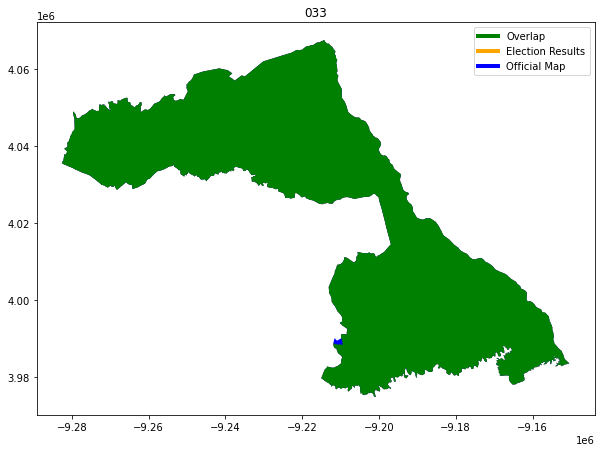

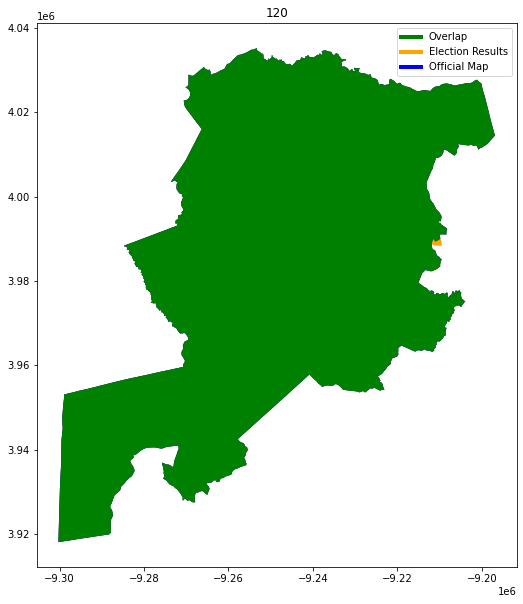

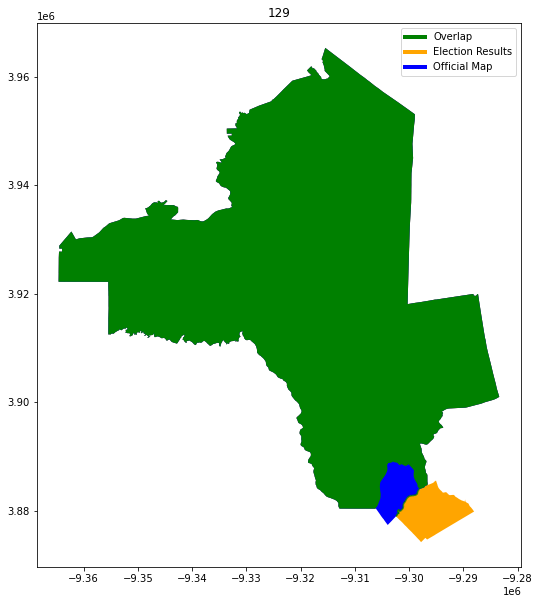

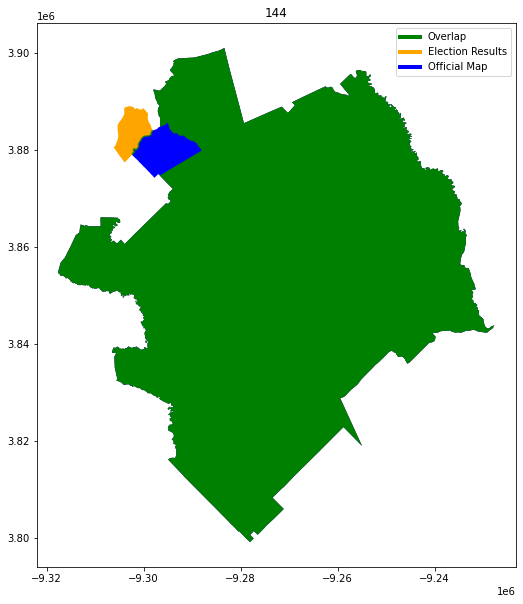

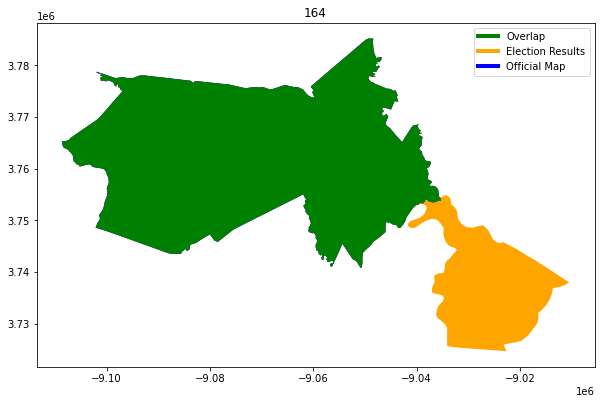

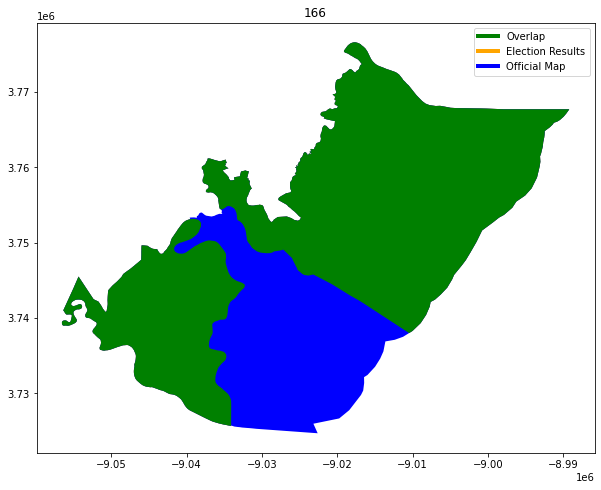

In [49]:
helper_functions.compare_geometries(assigned_districts, ga_sldl_districts ,"Election Results", "Official Map", "SLDL_DIST",area_threshold=.1)

## Check Added Column Totals

In the 'statewide-county-totals-check-erj' we created a cleaned csv of the county totals from the GA sos website

In [50]:
official_county_totals = pd.read_csv("./cleaned_official_county_totals.csv")

In [51]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", join_attempt_1, "ERJ Totals", races)

***Statewide Totals Check***
GSL001RCAM is equal 	 both dataframes 19371
GSL002RTAR is equal 	 both dataframes 21983
GSL003RHIL is equal 	 both dataframes 23054
GSL004RCAR is equal 	 both dataframes 13377
GSL005RBAR is equal 	 both dataframes 19421
GSL006RRID is equal 	 both dataframes 18227
GSL007DDAY is equal 	 both dataframes 5255
GSL007RRAL is equal 	 both dataframes 27074
GSL008DCOO is equal 	 both dataframes 6407
GSL008RGUN is equal 	 both dataframes 29195
GSL009DRAV is equal 	 both dataframes 5046
GSL009RWAD is equal 	 both dataframes 26310
GSL010DMIT is equal 	 both dataframes 4116
GSL010RAND is equal 	 both dataframes 21396
GSL011DHOL is equal 	 both dataframes 4272
GSL011RJAS is equal 	 both dataframes 22633
GSL012DGIL has a difference of 47 votes
	Official Totals: 4114 votes
	ERJ Totals: 4067 votes
GSL012RLUM has a difference of 134 votes
	Official Totals: 17666 votes
	ERJ Totals: 17532 votes
GSL013RDEM is equal 	 both dataframes 17421
GSL014RSCO is equal 	 both dataframes 2

In [52]:
ga_election["CTYNAME"] = ga_election["county"].str.upper()

## Check whether the differences above were introduced from the precinct splits

Note: It appears as though they were

In [53]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", ga_election, "Pre-Split Totals", races)

***Statewide Totals Check***
GSL001RCAM is equal 	 both dataframes 19371
GSL002RTAR is equal 	 both dataframes 21983
GSL003RHIL is equal 	 both dataframes 23054
GSL004RCAR is equal 	 both dataframes 13377
GSL005RBAR is equal 	 both dataframes 19421
GSL006RRID is equal 	 both dataframes 18227
GSL007DDAY is equal 	 both dataframes 5255
GSL007RRAL is equal 	 both dataframes 27074
GSL008DCOO is equal 	 both dataframes 6407
GSL008RGUN is equal 	 both dataframes 29195
GSL009DRAV is equal 	 both dataframes 5046
GSL009RWAD is equal 	 both dataframes 26310
GSL010DMIT is equal 	 both dataframes 4116
GSL010RAND is equal 	 both dataframes 21396
GSL011DHOL is equal 	 both dataframes 4272
GSL011RJAS is equal 	 both dataframes 22633
GSL012DGIL is equal 	 both dataframes 4114
GSL012RLUM is equal 	 both dataframes 17666
GSL013RDEM is equal 	 both dataframes 17421
GSL014RSCO is equal 	 both dataframes 24279
GSL015RGAM is equal 	 both dataframes 22536
GSL016DARR is equal 	 both dataframes 5074
GSL016RKEL

## Check Column Totals - County Level

In [54]:
official_county_totals["CTYNAME"] = official_county_totals["county"].str.upper()

In [55]:
helper_functions.county_totals_check(official_county_totals, "Official Totals", join_attempt_1, "ERJ Totals", races, "CTYNAME")

***Countywide Totals Check***

GSL001RCAM is equal across all counties
GSL002RTAR is equal across all counties
GSL003RHIL is equal across all counties
GSL004RCAR is equal across all counties
GSL005RBAR is equal across all counties
GSL006RRID is equal across all counties
GSL007DDAY is equal across all counties
GSL007RRAL is equal across all counties
GSL008DCOO is equal across all counties
GSL008RGUN is equal across all counties
GSL009DRAV is equal across all counties
GSL009RWAD is equal across all counties
GSL010DMIT is equal across all counties
GSL010RAND is equal across all counties
GSL011DHOL is equal across all counties
GSL011RJAS is equal across all counties
GSL012DGIL contains differences in these counties:
	FLOYD has a difference of 47 votes
		Official Totals: 2357 votes
		ERJ Totals: 2310 votes
GSL012RLUM contains differences in these counties:
	FLOYD has a difference of 134 votes
		Official Totals: 9681 votes
		ERJ Totals: 9547 votes
GSL013RDEM is equal across all counties
GSL0

GSL121RFLE is equal across all counties
GSL122DCRU is equal across all counties
GSL122RLOT is equal across all counties
GSL123RNEW is equal across all counties
GSL124DHOW is equal across all counties
GSL125DNEL is equal across all counties
GSL126DFRA is equal across all counties
GSL127DPRI is equal across all counties
GSL128DJAC is equal across all counties
GSL129DBEL is equal across all counties
GSL129IREE is equal across all counties
GSL129RHOL is equal across all counties
GSL130DHEN is equal across all counties
GSL130RKNI is equal across all counties
GSL131DBEN is equal across all counties
GSL131RCAM is equal across all counties
GSL132DTRA contains differences in these counties:
	TROUP has a difference of 6 votes
		Official Totals: 6379 votes
		ERJ Totals: 6373 votes
GSL132RJEN contains differences in these counties:
	TROUP has a difference of 28 votes
		Official Totals: 5212 votes
		ERJ Totals: 5184 votes
GSL133RSMI contains differences in these counties:
	TROUP has a difference of

In [56]:
helper_functions.county_totals_check(official_county_totals, "Official Totals", ga_election, "Pre-Split Totals", races, "CTYNAME")

***Countywide Totals Check***

GSL001RCAM is equal across all counties
GSL002RTAR is equal across all counties
GSL003RHIL is equal across all counties
GSL004RCAR is equal across all counties
GSL005RBAR is equal across all counties
GSL006RRID is equal across all counties
GSL007DDAY is equal across all counties
GSL007RRAL is equal across all counties
GSL008DCOO is equal across all counties
GSL008RGUN is equal across all counties
GSL009DRAV is equal across all counties
GSL009RWAD is equal across all counties
GSL010DMIT is equal across all counties
GSL010RAND is equal across all counties
GSL011DHOL is equal across all counties
GSL011RJAS is equal across all counties
GSL012DGIL is equal across all counties
GSL012RLUM is equal across all counties
GSL013RDEM is equal across all counties
GSL014RSCO is equal across all counties
GSL015RGAM is equal across all counties
GSL016DARR is equal across all counties
GSL016RKEL is equal across all counties
GSL017DDAI is equal across all counties
GSL017RMO

GSL138RCHE is equal across all counties
GSL139DBEN is equal across all counties
GSL140RDIC is equal across all counties
GSL141RWAS is equal across all counties
GSL142DPAR is equal across all counties
GSL143DBEV is equal across all counties
GSL144DWHI is equal across all counties
GSL144RMAT is equal across all counties
GSL145DHOW is equal across all counties
GSL145RWIL is equal across all counties
GSL146RBLA is equal across all counties
GSL147DBAU is equal across all counties
GSL147RCLA is equal across all counties
GSL148DAWU is equal across all counties
GSL148RWIL is equal across all counties
GSL149RPRU is equal across all counties
GSL150RHAT is equal across all counties
GSL151DBAR is equal across all counties
GSL151RGRE is equal across all counties
GSL152RYEA is equal across all counties
GSL153DHOP is equal across all counties
GSL154DDUK is equal across all counties
GSL155DKIT is equal across all counties
GSL155RPIR is equal across all counties
GSL156RMOR is equal across all counties


## Prepare to Export

In [57]:
join_attempt_1.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'CTYNAME', 'CTYNUMBER', 'CTYNUMBER2', 'FIPS2',
       ...
       'GSL174RCOR', 'GSL175RLAH', 'GSL176DPRI', 'GSL176RBUR', 'GSL177DSHA',
       'GSL178RMEE', 'GSL179DJOR', 'GSL179RHOG', 'GSL180RSAI', 'geometry'],
      dtype='object', length=279)

In [58]:
join_attempt_1.to_file("./ga_gen_20_prec/ga_gen_20_sldl_prec.shp")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
